# Market Capitalization Data Discovery
[Portfolio Analysis](https://tradewithpython.com/portfolio-analysis-using-python)

After unzip files into folder, read all the files into a list

In [1]:
'''
    WARNING CONTROL to display or ignore all warnings
'''
import warnings; warnings.simplefilter('default')     #switch betweeb 'default' and 'ignore'

''' Set debug flag to view extended error messages; else set it to False to turn off debugging mode '''
debug = True

In [25]:
import sys
sys.path.insert(1, '../lib')
import dataETL as etl
import pandas as pd

if debug:
    import importlib
    etl = importlib.reload(etl)

''' Initialize the dataETL class '''
path = "../data/market_cap_2021-01-01_2022-06-01/"
cls_etl = etl.ExtractLoadTransform(dataPath=path)
''' Get list of data file names '''
_l_fnames = cls_etl.get_file_list()
print("Retrieved %d files in dir: %s " % (len(_l_fnames),path))
''' Load data into dataframe '''
data_df = cls_etl.load_data(_l_fnames)
print("Loaded %d rows %s" % (data_df.shape[0],str(data_df.columns)))
''' Transform data with coin ids in columns '''
market_df = cls_etl.transfrom_data(data_df, value_col_name='market_cap')
print(market_df.info())
print("Market cap data load & transform complete! ")

Retrieved 63 files in dir: ../data/market_cap_2021-01-01_2022-06-01/ 
Loaded 3637 rows Index(['Date', 'ID', 'Symbol', 'market_cap'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524 entries, 0 to 523
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          524 non-null    datetime64[ns]
 1   bitcoin       524 non-null    float64       
 2   bitcoin_cash  493 non-null    float64       
 3   cardano       524 non-null    float64       
 4   ethereum      524 non-null    float64       
 5   litecoin      524 non-null    float64       
 6   ripple        524 non-null    float64       
 7   solana        524 non-null    float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 32.9 KB
None
Market cap data load & transform complete! 


## Probability distribution of the data

bitcoin
[distfit] >fit..
[distfit] >transform..
[distfit] >[norm      ] [0.00 sec] [RSS: 0.0000000] [loc=844759583949.448 scale=177814487906.911]
[distfit] >[expon     ] [0.00 sec] [RSS: 0.0000000] [loc=539438036435.670 scale=305321547513.777]
[distfit] >[pareto    ] [0.10 sec] [RSS: 0.0000000] [loc=-1489314542.428 scale=540927350978.093]
[distfit] >[dweibull  ] [0.05 sec] [RSS: 0.0000000] [loc=852575933591.105 scale=163926210317.947]
[distfit] >[t         ] [0.10 sec] [RSS: 0.0000000] [loc=828124158839.043 scale=178032305518.715]
[distfit] >[genextreme] [0.29 sec] [RSS: 0.0000000] [loc=539438036435.710 scale=0.505]
[distfit] >[gamma     ] [0.08 sec] [RSS: 0.0000000] [loc=424470540173.168 scale=81959694216.554]
[distfit] >[lognorm   ] [0.18 sec] [RSS: 0.0000000] [loc=539438036435.670 scale=1.231]
[distfit] >[beta      ] [0.13 sec] [RSS: 0.0000000] [loc=538499788286.801 scale=751444689363.332]
[distfit] >[uniform   ] [0.00 sec] [RSS: 0.0000000] [loc=539438036435.670 scale=739359859092.6

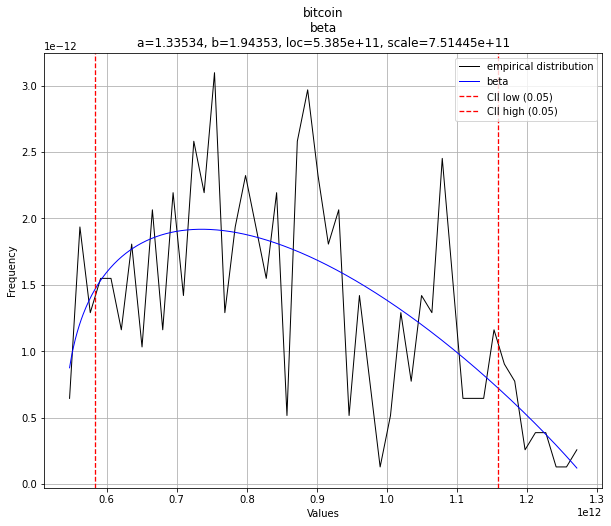

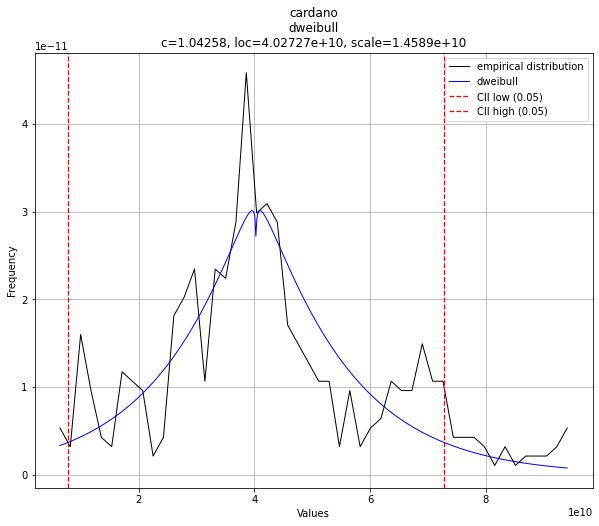

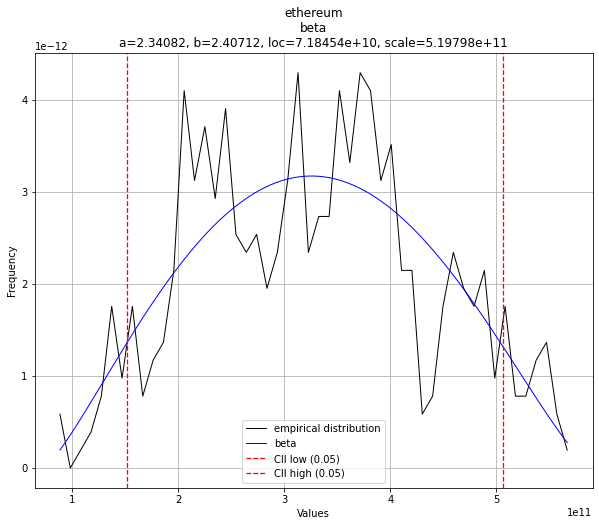

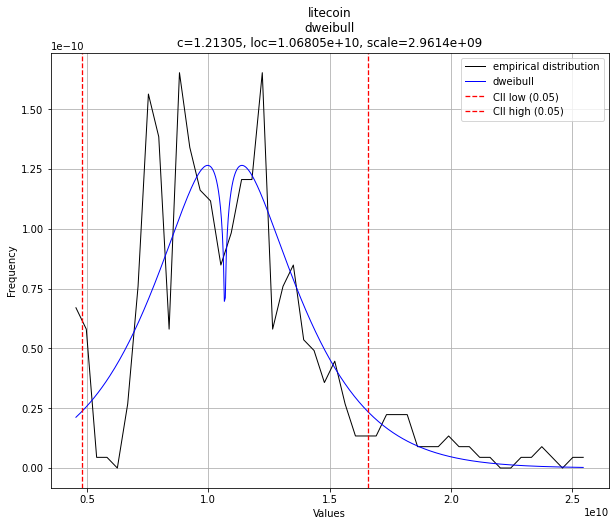

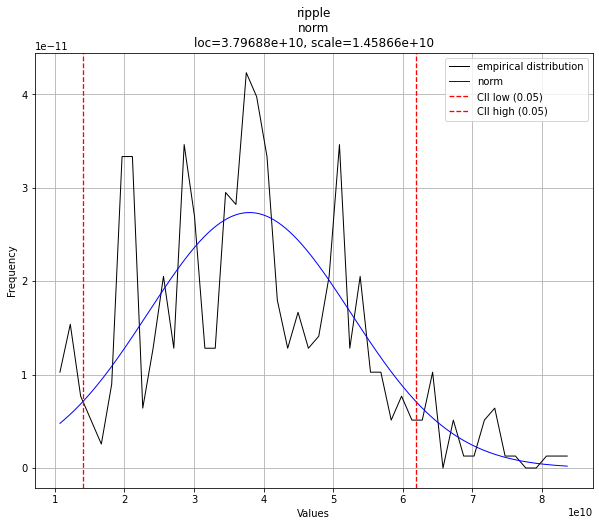

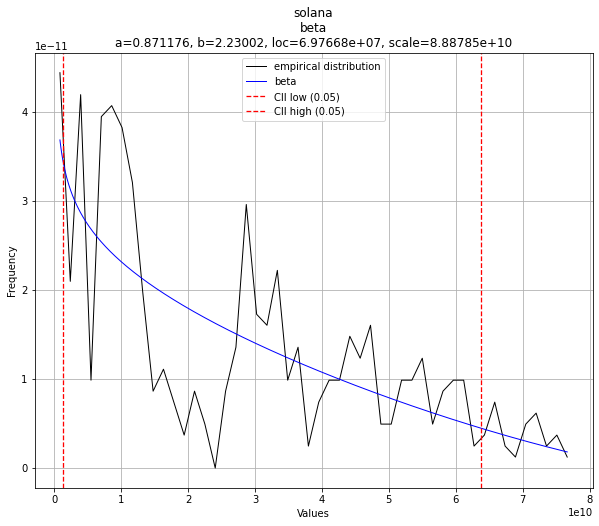

In [42]:
#%%capture
from distfit import distfit

_l_dist = []
dist = distfit(distr='popular')
market_df.replace("", np.nan, inplace=True)
market_df.dropna(how='all', axis=1, inplace=True)

''' list of all the numerical data columns '''
_l_num_cols=market_df.select_dtypes(include=np.number).columns.tolist()
_l_num_cols = [col for col in _l_num_cols if col !='bitcoin_cash']
for col in _l_num_cols:
    print(col)
    _col_vals = market_df[col].values
    ''' initialize distfit'''
    dist.fit_transform(_col_vals)
    ''' print the summary results '''
    dist.plot(title=col)


## Filter by date range

In [5]:
import datetime

start_dt = datetime.datetime(2022,1,1)
end_dt = datetime.datetime(2022,2,1)

''' >= start-date '''
if isinstance(start_dt, datetime.date):
    mask = (market_df["Date"] >= start_dt)
    market_df = market_df[mask]
''' <= end-date '''
if isinstance(end_dt, datetime.date):
    mask = (market_df["Date"] <= end_dt)
    market_df = market_df[mask]
market_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32 entries, 365 to 396
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          32 non-null     datetime64[ns]
 1   bitcoin       32 non-null     float64       
 2   bitcoin_cash  32 non-null     float64       
 3   cardano       32 non-null     float64       
 4   ethereum      32 non-null     float64       
 5   litecoin      32 non-null     float64       
 6   ripple        32 non-null     float64       
 7   solana        32 non-null     float64       
dtypes: datetime64[ns](1), float64(7)
memory usage: 2.2 KB


## Market capital
Plot the market capital time series to see the behaviour

In [7]:
import plotly.express as px

market_cap_df = market_df.copy()
_min_date = (market_cap_df["Date"].min()).date()
_max_date = (market_cap_df["Date"].max()).date()
_title = "Market Capitalization from "+str(_min_date)+" to "+str(_max_date)
fig = px.scatter(market_cap_df, x="Date", y=market_cap_df.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

/home/gnewy/.local/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



# Index by Market Caps

Apply the [custom market cap index based method](https://medium.com/python-financial-analysis/python-financial-analysis-4-3-market-cap-based-index-329b908f75dc). 
1. sort the table by the market cap in descending order
1. take just the first N rows
1. get tickers that belong to the Ns, and transform it to a list “tickers_topN”
1. iterate over the N tickers
   1. market_cap” selects a column
      1. multiply the weight “w” to created column “marketcap_weighted_ave_topN”

In [9]:
import plotly.express as px

_weighted_market_df = market_df.copy()
_min_date = (_weighted_market_df["Date"].min()).date()
_max_date = (_weighted_market_df["Date"].max()).date()
_l_coin_ids = list(_weighted_market_df.columns)
_l_coin_ids.remove('Date')

for coin in _l_coin_ids:
    weighted_col_name = "weighted_"+coin
    _weighted_market_df[weighted_col_name]=_weighted_market_df[coin]/_weighted_market_df[coin].sum()

_l_weighted_cols = [x for x in _weighted_market_df.columns if x not in _l_coin_ids]
plot_weighted_market_df = _weighted_market_df[_l_weighted_cols]

_title = "Weighted Market Capitalization Index from "+str(_min_date)+" to "+str(_max_date)
fig = px.line(plot_weighted_market_df, x="Date", y=plot_weighted_market_df.columns,
              hover_data={"Date": "|%Y-%m-%d, "},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

/home/gnewy/.local/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Simple Returns
1. Compute the ___percentage change___ between the current and a prior value, for each coin.
1. Plot the returns to examine coins with high and low ___volatility___.

In [10]:
''' Daily simple returns '''
import datetime
import plotly.express as px

simple_returns_df = market_df.copy()
_min_date = (simple_returns_df["Date"].min()).date()
_max_date = (simple_returns_df["Date"].max()).date()

simple_returns_df = market_df[_l_coin_ids].pct_change(periods=1)
simple_returns_df["Date"] = market_df["Date"]   #.astype('datetime[ns]')

_title = "Expected Returns from "+str(_min_date)+" to "+str(_max_date)
fig = px.line(simple_returns_df, x="Date", y=simple_returns_df.columns,
              hover_data={"Date": "|%B %d, %Y"},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

/home/gnewy/.local/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Average Daily Returns
Calculate the average daily returns for each coin

In [11]:
print('Average Daily returns(%) of coins:\n')
Avg_daily = simple_returns_df.mean()
print(Avg_daily*100)
#print(Avg_daily)

Average Daily returns(%) of coins:

bitcoin        -0.557628
bitcoin_cash         NaN
cardano        -0.582291
ethereum       -0.923301
litecoin       -0.846301
ripple         -0.878567
solana         -1.514625
dtype: float64


/tmp/ipykernel_44502/3504244102.py:2: FutureWarning:

DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.



## Risk of Daily Returns
The box plot will reveal the:
1. largest spread in the box plot shows the coin with the highest _average daily returns_
1. coin with the positive outliers translates into a higher average daily return

In [12]:
import plotly.express as px

_title = "Risk Box Plot from "+str(_min_date)+" to "+str(_max_date)

df = simple_returns_df[_l_coin_ids].melt(var_name="quartilemethod")

fig = px.box(df, facet_col="quartilemethod", color="quartilemethod",
             boxmode="overlay", points='all', title=_title)

for col_idx, col_name in enumerate(_l_coin_ids):
    # use: quartilemethod = {linear, inclusive, exclusive}
    fig.update_traces(quartilemethod="linear", jitter=0, col=col_idx)
fig.show()

/home/gnewy/.local/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## Returns Per Unit Risk
1. Calculate each coins' ___standard deviation___
1. Calculate ___periodic standard deviation___ (annualized standard deviation)
1. Coin with higher ratio is better beacuse it has the best ___Return to Risk ratio___
1. Also known as the ___Sharpe Ratio___
   1. it is a measure of risk-adjusted return
   1. it describes how much excess return is  receive for the volatility of holding a riskier asset

In [13]:
from datetime import datetime
import numpy as np

#max_date = simple_returns_df['Date'].max()
#min_date = simple_returns_df['Date'].min()
Ndays = (_max_date - _min_date).days

print("Annualized Standard Deviation Volatality for %s trading days" % (str(Ndays)))
print("of individual coins on the basis of daily simple returns.")
print(simple_returns_df[_l_coin_ids].std().astype('float64')  * np.sqrt(Ndays).astype('float64') * 100.0)
#print(simple_returns_df.std() * np.sqrt(Ndays) * 100)

Annualized Standard Deviation Volatality for 31 trading days
of individual coins on the basis of daily simple returns.
bitcoin         15.461410
bitcoin_cash          NaN
cardano         29.902032
ethereum        23.998057
litecoin        22.840896
ripple          18.407503
solana          31.297766
dtype: float64


## Cummilative Product

In [14]:
import plotly.express as px

_investment = 1.0 # USD

_cum_prod_df = market_df.copy()
_min_date = (_cum_prod_df["Date"].min()).date()
_max_date = (_cum_prod_df["Date"].max()).date()
_cum_prod_df = _cum_prod_df[_l_coin_ids].pct_change(periods=1)
daily_cummulative_simple_return = (_cum_prod_df[_l_coin_ids]+_investment).cumprod()
daily_cummulative_simple_return = pd.concat([daily_cummulative_simple_return,market_df['Date']],axis=1)

_title = "Daily Cummulative Simple returns/growth of investment from "\
            +str(_min_date)+" to "+str(_max_date)
fig = px.line(daily_cummulative_simple_return, x="Date", y=daily_cummulative_simple_return.columns,
              hover_data={"Date": "|%Y-%m-%d, "},
              title=_title)
fig.update_xaxes(
    dtick="M1",
    tickformat="%b\n%Y")
fig.show()

/home/gnewy/.local/lib/python3.8/site-packages/plotly/io/_renderers.py:396: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



## DEPRECATED

## Explore folder

In [108]:
# import OS module
import os
 
# Get the list of all files and directories
path = "../data/market_cap_2021-01-01_2022-06-01/"
dir_list = os.listdir(path)
print("%d files in directory %s" % (len(dir_list),path))

Files and directories in  ./data/market_cap_2021-01-01_2022-06-01/
63 files in directory ./data/market_cap_2021-01-01_2022-06-01/


## Read files into dataframe

In [109]:
import pandas as pd

columns = ["Date","ID","Symbol","market_cap"]
data_df = pd.DataFrame([],columns=columns)
for _s_file in dir_list:
    if _s_file.endswith(".csv"):
        _s_rel_path = path+_s_file
        _tmp_df = pd.read_csv(_s_rel_path, index_col=False)
        data_df = pd.concat([data_df,_tmp_df[columns]])
data_df.reset_index(drop=True)
print(data_df.info())
print("Data load complete!")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3637 entries, 0 to 60
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        3637 non-null   object
 1   ID          3637 non-null   object
 2   Symbol      3637 non-null   object
 3   market_cap  3637 non-null   object
dtypes: object(4)
memory usage: 142.1+ KB
None
Data load complete!


## Transform data to columns

In [19]:
import pandas as pd

''' Initialize variables '''
_l_coin_ids = sorted(data_df['ID'].unique())
_l_dates = sorted(data_df['Date'].unique())
_l_columns = list(sorted(data_df['ID'].unique()))
_l_columns.insert(0,"Date")

market_df = pd.DataFrame([], columns=_l_columns)
market_df["Date"] = _l_dates

for _s_coin_id in _l_coin_ids:
    tmp_df = pd.DataFrame([])
    tmp_df = data_df.loc[data_df["ID"] == _s_coin_id]
    tmp_df = tmp_df.sort_values(by=['Date'])
    tmp_df = tmp_df.dropna(inplace=False)
    print("%s coin with %d rows" % (_s_coin_id,tmp_df.shape[0]))
    for _date in tmp_df["Date"]:
        _value = tmp_df.loc[tmp_df['Date'] == _date, "market_cap"].item()
        market_df.loc[market_df['Date']==_date, _s_coin_id] = _value

''' Cleanup rows and columns '''
market_df=market_df.drop_duplicates()
market_df = market_df.dropna(axis=1)

''' Set the dtypes '''
market_df['Date'] = market_df['Date'].astype('datetime64[ns]')
market_df.loc[:,market_df.columns !='Date'] = market_df.loc[:,market_df.columns !='Date'].astype('float64')

print(market_df.info())

bitcoin coin with 524 rows
bitcoin_cash coin with 493 rows
cardano coin with 524 rows
ethereum coin with 524 rows
litecoin coin with 524 rows
ripple coin with 524 rows
solana coin with 524 rows
           Date              bitcoin             cardano             ethereum  \
0    2021-01-01  539438036435.670105   5664962992.375575   84037694047.355148   
1    2021-01-02  545593282215.249817   5459442449.830887    83294083323.20639   
2    2021-01-03   597887713053.58252   5541071871.348484   88595346035.551559   
3    2021-01-04  613616917625.696655   6478554204.432761  112525376104.654541   
4    2021-01-05  585726270248.789062   6776976218.184067  116693162132.749344   
..          ...                  ...                 ...                  ...   
519  2022-06-04  566275595800.177246  18946974767.650925  214879733566.941986   
520  2022-06-05  568340135127.331055  19061063639.607044  217832477905.494965   
521  2022-06-06   570209935092.42749  19252585858.211929  218561175507.620911